

#Step 1

**Target :**
*   Setup working code
*   Train and test functions
*   dataset loaders

**Result :**
*   Total params: 15,408 
*   Best train accuracy : 99.23 
*   Best test accuracy : 98.95

**Analysis :**
*   Basic code works fine. 
*   Number of parameters are less than target parameters.
*   Train and test accuracy to be improved.
*   Also model is overfitting.


# Code Setup

In [ ]:
!pip install torchsummary

# Imports

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Data Transformations

Here we define train and test transforms. We add Normalisation and other Data Augmentation transforms and will use if needed.

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset Train-Test Split

We download the data and make the test train split.

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Data Loader and Test/Train Data Loaders

Here we define data loaders and test train loaders and also the set the seed value to reproduce the results.

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Stats

Statistics is important. We see some sample of the data here because that helps in analysing the data for augmentation

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


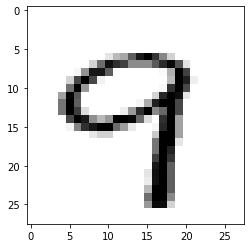

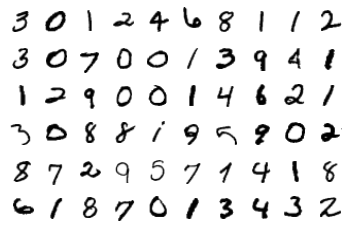

In [ ]:

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Defining Model Architecture

Here we define the convolution blocks and the forward function.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  #Input-28x28x1 | Output-26x26x16 | RF -3x3
            nn.ReLU()
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  #Input-26x26x16 | Output-24x24x16 | RF - 5x5
            nn.ReLU()
        ) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  #Input-24x24x16 | Output-22x22x16 | RF - 7x7
            nn.ReLU()
        ) 

        self.pool1 = nn.MaxPool2d(2, 2)  #Input-22x22x16 | Output-11x11x16 | RF - 8x8

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input-11x11x16 | Output-9x9x16 | RF - 12x12
            nn.ReLU()
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input-9x9x16 | Output-7x7x16 | RF - 16x16
            nn.ReLU()
        ) 
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input-7x7x16 | Output-5x5x16 | RF - 20x20
            nn.ReLU()
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input-5x5x16 | Output-3x3x10 | RF - 24x24
            nn.ReLU()
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), #Input-3x3x16 | Output-1x1x10 | RF - 28x28
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Parameters

We print the model parameters by giving dummy input to torchsummary

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,304
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,304
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8             [-1, 16, 9, 9]           2,304
              ReLU-9             [-1, 16, 9, 9]               0
           Conv2d-10             [-1, 16, 7, 7]           2,304
             ReLU-11             [-1, 16, 7, 7]               0
           Conv2d-12             [-1, 16, 5, 5]           2,304
             ReLU-13             [-1, 16, 5, 5]               0
           Conv2d-14             [

# Training and Testing Functions

Here we define the train and test functions and also the progress bar.

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Code Execution

Final code execution.
Also define stepLR for later use.

In [ ]:
#from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.20233117043972015 Batch_id=468 Accuracy=37.20: 100%|██████████| 469/469 [00:12<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3290, Accuracy: 8977/10000 (89.77%)

EPOCH: 1


Loss=0.03355925902724266 Batch_id=468 Accuracy=93.71: 100%|██████████| 469/469 [00:12<00:00, 37.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1110, Accuracy: 9649/10000 (96.49%)

EPOCH: 2


Loss=0.028648972511291504 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:11<00:00, 41.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9778/10000 (97.78%)

EPOCH: 3


Loss=0.020251421257853508 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:11<00:00, 42.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9831/10000 (98.31%)

EPOCH: 4


Loss=0.037002433091402054 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:10<00:00, 43.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9849/10000 (98.49%)

EPOCH: 5


Loss=0.03081982024013996 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:11<00:00, 42.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.017383379861712456 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:10<00:00, 42.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9877/10000 (98.77%)

EPOCH: 7


Loss=0.02024713344871998 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:11<00:00, 42.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9870/10000 (98.70%)

EPOCH: 8


Loss=0.05390837416052818 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:10<00:00, 43.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.010861873626708984 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 44.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9885/10000 (98.85%)

EPOCH: 10


Loss=0.01628311350941658 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:10<00:00, 42.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9868/10000 (98.68%)

EPOCH: 11


Loss=0.013725961558520794 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:10<00:00, 43.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9885/10000 (98.85%)

EPOCH: 12


Loss=0.005615660455077887 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:10<00:00, 43.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.07758637517690659 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:10<00:00, 44.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.002687546657398343 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:10<00:00, 44.85it/s]



Test set: Average loss: 0.0387, Accuracy: 9887/10000 (98.87%)

